<a href="https://colab.research.google.com/github/avinashkpai12/Pytorch_Projects/blob/master/Face_Similarity_using_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Similarity - Siamese Networks
The goal is to teach the Siamese Network to distinguish pairs of images.
The above will be achieved by performing the following steps:
1. Load the modules, data.
2. Data Processing - creating image pairs
3. Building the Siamese Network
4. Training.
5. Inference 

# 1. Loading Modules, data and utility functions

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Creating Image show and Plotting Functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Download the dataset - AT&T Faces Dataset
Source - https://www.kaggle.com/kasikrit/att-database-of-faces

In [4]:
# Download and unzip our data
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/face_data.zip
!unzip -q face_data.zip

--2022-11-20 23:54:52--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/face_data.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.148.86
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.148.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3821906 (3.6M) [application/zip]
Saving to: ‘face_data.zip.1’

face_data.zip.1     100%[===================>]   3.64M  5.35MB/s    in 0.7s    

2022-11-20 23:54:54 (5.35 MB/s) - ‘face_data.zip.1’ saved [3821906/3821906]

replace data/faces/training/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
# Creating class that stores the train and test parameters
class Config:
  training_dir = './data/faces/training/'
  testing_dir = './data/faces/testing/'
  train_batch_size = 64
  train_number_epochs = 100

In [6]:
# Setup Data processing - Creating Image pairs
class SiameseNetworkDataset(Dataset):
  def __init__(self, imageFolderDataset, transform=None, should_invert=True):
    self.imageFolderDataset = imageFolderDataset
    self.transform = transform
    self.should_invert = should_invert
  
  def __getitem__(self, index):
    img0_tuple = random.choice(self.imageFolderDataset.imgs)
    # need to ensure approximately 50% of the images are in the same class
    should_get_same_class = random.randint(0,1)
    if should_get_same_class:
      while True:
        img1_tuple = random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] == img1_tuple[1]:
          break
    else:
      while True:
        img1_tuple = random.choice(self.imageFolderDataset.imgs)
        if img0_tuple[1] != img1_tuple[1]:
          break
    
    img0 = Image.open(img0_tuple[0])
    img1 = Image.open(img1_tuple[0])
    img0 = img0.convert("L")
    img1 = img1.convert("L")

    if self.should_invert:
      img0 = PIL.ImageOps.invert(img0)
      img1 = PIL.ImageOps.invert(img1)

    if self.transform is not None:
      img0 = self.transform(img0)
      img1 = self.transform(img1)

    return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype= np.float32))

  def __len__(self):
    return len(self.imageFolderDataset.imgs)
      

In [7]:
# Image folders
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
# creating transforms
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100, 100)),
                                                                      transforms.ToTensor()]),
                                        should_invert=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


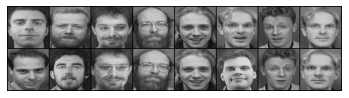

[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [9]:
# Creating dataloader and analysing samples
img_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=8,
                            batch_size=8)

dataiter = iter(img_dataloader)

test_batch = next(dataiter)
concatenated = torch.cat((test_batch[0], test_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(test_batch[2].numpy())

In [10]:
from prompt_toolkit import output
from torch.nn.modules.padding import ReflectionPad2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.batchnorm import BatchNorm2d
# The Siamese Network
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.cnn1 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(1, 4, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(4),

        nn.ReflectionPad2d(1),
        nn.Conv2d(4, 8, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),

        nn.ReflectionPad2d(1),
        nn.Conv2d(8, 8, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),)
    
    self.fc1 = nn.Sequential(
        nn.Linear(8*100*100, 500),
        nn.ReLU(inplace=True),

        nn.Linear(500, 500),
        nn.ReLU(inplace=True),

        nn.Linear(500, 5),
    )

  def forward_once(self, x):
    output = self.cnn1(x)
    output = output.view(output.size()[0], -1)
    output = self.fc1(output)
    return output
  
  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [11]:
# Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):

  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
  
  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    
    return loss_contrastive

In [13]:
# Create Train Dataloader
train_loader = DataLoader(siamese_dataset,
                          shuffle= True,
                          num_workers=4,
                          batch_size=Config.train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# Loss and optimizer
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr= 0.0005)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch Number 0
 Current Loss 1.5744332075119019

Epoch Number 1
 Current Loss 1.89824640750885

Epoch Number 2
 Current Loss 1.8572299480438232

Epoch Number 3
 Current Loss 0.9679609537124634

Epoch Number 4
 Current Loss 0.7368971705436707

Epoch Number 5
 Current Loss 0.4626498818397522

Epoch Number 6
 Current Loss 0.3309803307056427

Epoch Number 7
 Current Loss 0.2182963788509369

Epoch Number 8
 Current Loss 0.32482075691223145

Epoch Number 9
 Current Loss 0.2414947748184204

Epoch Number 10
 Current Loss 0.14375725388526917

Epoch Number 11
 Current Loss 0.17929238080978394

Epoch Number 12
 Current Loss 0.17328041791915894

Epoch Number 13
 Current Loss 0.09582894295454025

Epoch Number 14
 Current Loss 0.11668811738491058

Epoch Number 15
 Current Loss 0.11120210587978363

Epoch Number 16
 Current Loss 0.11729079484939575

Epoch Number 17
 Current Loss 0.07754337042570114

Epoch Number 18
 Current Loss 0.07329963147640228

Epoch Number 19
 Current Loss 0.06857656687498093

E

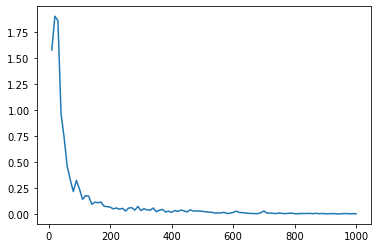

In [15]:
# Training
counter = []
loss_history = []
iteration = 0

for epoch in range(0, Config.train_number_epochs):
  for i, data in enumerate(train_loader, 0):
    img0, img1, label = data
    img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    optimizer.zero_grad()
    output1, output2 = net(img0, img1)
    loss_contrastive = criterion(output1, output2, label)
    loss_contrastive.backward()
    optimizer.step()
    if i%10 == 0:
      print("Epoch Number {}\n Current Loss {}\n".format(epoch, loss_contrastive.item()))
      iteration += 10
      counter.append(iteration)
      loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


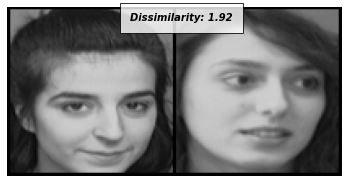

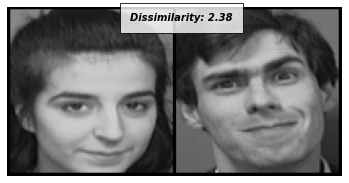

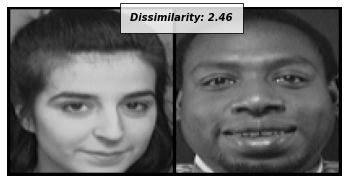

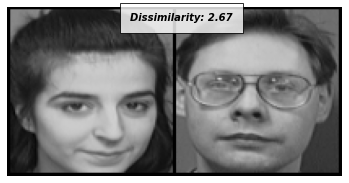

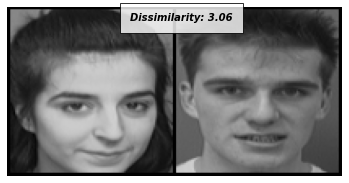

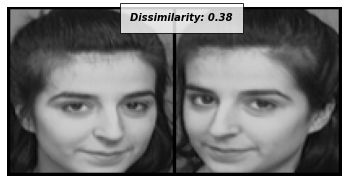

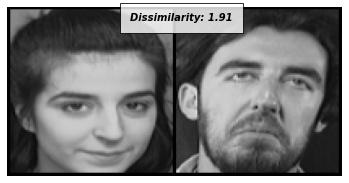

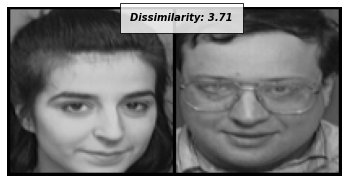

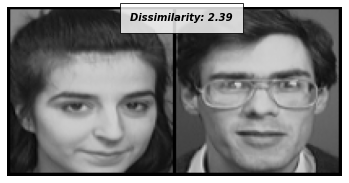

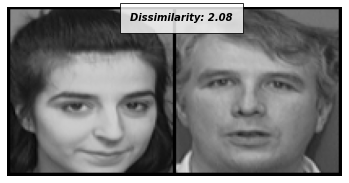

In [17]:
# Test Results
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100, 100)),
                                                                      transforms.ToTensor()]),
                                        should_invert=False)

test_loader = DataLoader(siamese_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_loader)
x0,_,_ = next(dataiter)

for i in range(10):
  _, x1, label2 = next(dataiter)
  concatenated = torch.cat((x0, x1), 0)

  output1, output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
  euclidean_distance = F.pairwise_distance(output1, output2)
  imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))